# Explainable AI (XAI)

### Data Mining Project 2024/25

Authors: Nicola Emmolo, Simone Marzeddu, Jacopo Raffi

In [15]:
#to find the best set of parameter setting, we can run a grid search
import pandas as pd
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import random
import numpy as np
import seaborn as sb

from sklearn import tree
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
import wittgenstein as lw
import keras_tuner
import keras
from keras_tuner import HyperParameters
import tensorflow as tf

import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from statistics import mean, stdev
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import classification_report, f1_score
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from scipy.stats import loguniform as sp_loguniform
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score
import shap

In [2]:
RANDOM_STATE = 42
train_set = pd.read_csv('../data/ml_datasets/oversampling/train_set.csv').sample(frac = 1, random_state=RANDOM_STATE) # shuffling the data so not to introduce bias
val_set = pd.read_csv('../data/ml_datasets/oversampling/val_set.csv').sample(frac = 1, random_state=RANDOM_STATE) # shuffling the data so not to introduce bias
test_set = pd.read_csv('../data/ml_datasets/oversampling/test_set.csv')

dev_set = pd.concat([train_set, val_set])

In [3]:
dev_set['race_season%autumn'] = dev_set['race_season%autumn'].astype(int)
dev_set['race_season%spring'] = dev_set['race_season%spring'].astype(int)
dev_set['race_season%summer'] = dev_set['race_season%summer'].astype(int)
dev_set['race_season%winter'] = dev_set['race_season%winter'].astype(int)

test_set['race_season%autumn'] = test_set['race_season%autumn'].astype(int)
test_set['race_season%spring'] = test_set['race_season%spring'].astype(int)
test_set['race_season%summer'] = test_set['race_season%summer'].astype(int)
test_set['race_season%winter'] = test_set['race_season%winter'].astype(int)

In [4]:
dev_label = dev_set.pop('label')
test_label = test_set.pop('label')

In [6]:
model = RandomForestClassifier(class_weight=None, criterion='entropy', max_features=8, min_samples_leaf=5, min_samples_split=20, n_estimators=150)
model.fit(dev_set, dev_label)

test_predicitions = model.predict(test_set)
dev_predictions = model.predict(dev_set)

In [7]:
perturbation_data = dev_set
perturbation_labels = dev_label
perturbation_predictions = dev_predictions

explanation_data = test_set
explanation_labels = test_label
explanation_predictions = test_predicitions

explanations = dict()

In [8]:
interventional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    data=dev_set,                       # perturb on a causal model induced on perturbation data
    feature_perturbation="interventional"  # use a causal model
)

distributional_explanation_algorithm = shap.TreeExplainer(
    model=model,
    feature_perturbation="tree_path_dependent"  # condition on the distribution learned on the train data
)

In [9]:
interventional_explanations = interventional_explanation_algorithm(explanation_data)
distributional_explanations = distributional_explanation_algorithm(explanation_data)

explanations["shap_interventional"] = interventional_explanations.values
explanations["shap_distributional"] = distributional_explanations.values

100%|===================| 31643/31649 [28:08<00:00]        

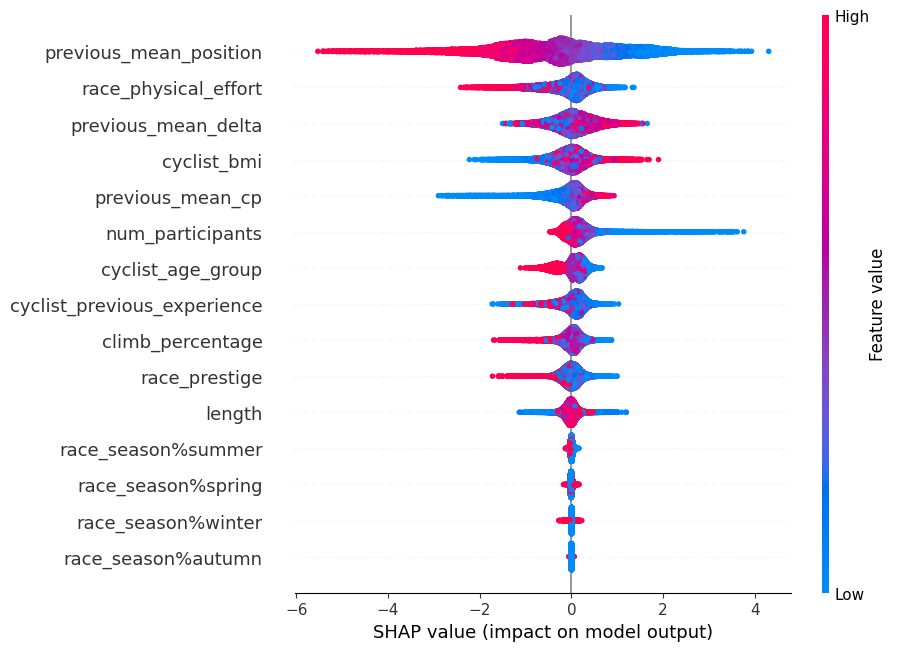

In [11]:
shap.plots.beeswarm(interventional_explanations, max_display=20)

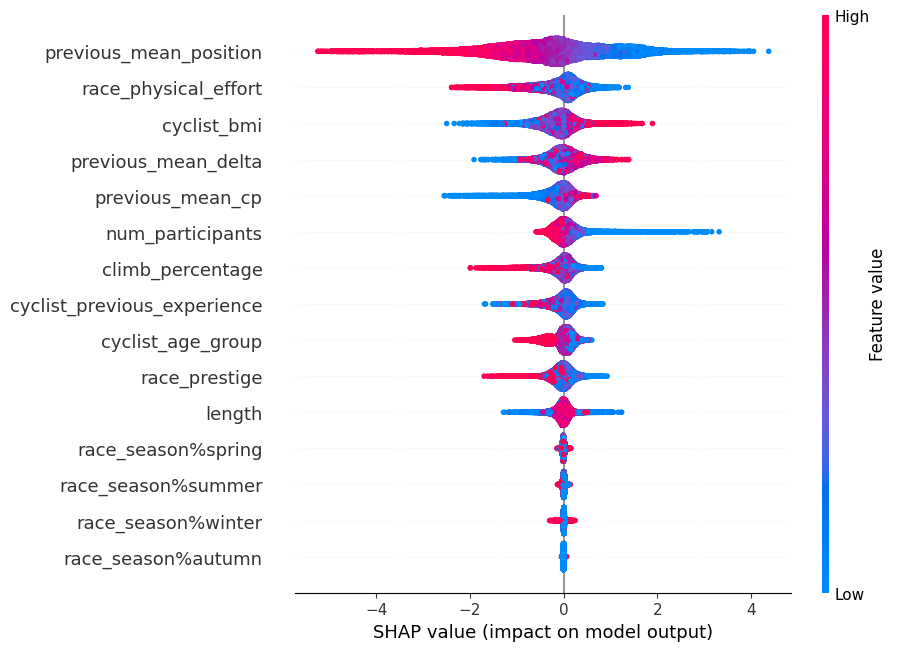

In [12]:
shap.plots.beeswarm(distributional_explanations, max_display=20)

In [16]:
explanation_differences = interventional_explanations.values - distributional_explanations.values
scaling_value = max((abs(interventional_explanations.values).max(), abs(distributional_explanations.values).max()))
maximum_differences_per_instance = explanation_differences.max(axis=1)
maximum_differences_per_feature = explanation_differences.max(axis=0)

<Axes: ylabel='Density'>

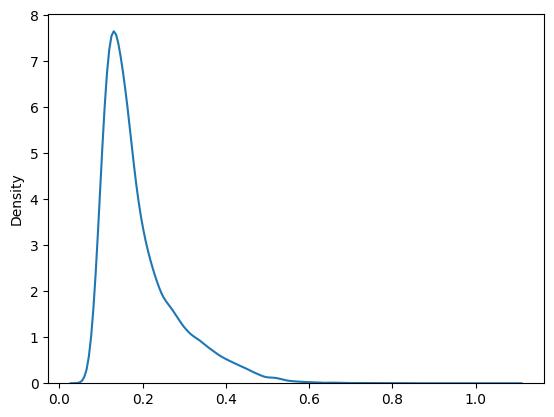

In [17]:
sb.kdeplot(maximum_differences_per_instance)

['length', 'cyclist_bmi', 'cyclist_age_group', 'climb_percentage', 'race_physical_effort', 'race_prestige', 'previous_mean_position', 'previous_mean_delta', 'previous_mean_cp', 'cyclist_previous_experience', 'num_participants', 'race_season%autumn', 'race_season%spring', 'race_season%summer', 'race_season%winter']


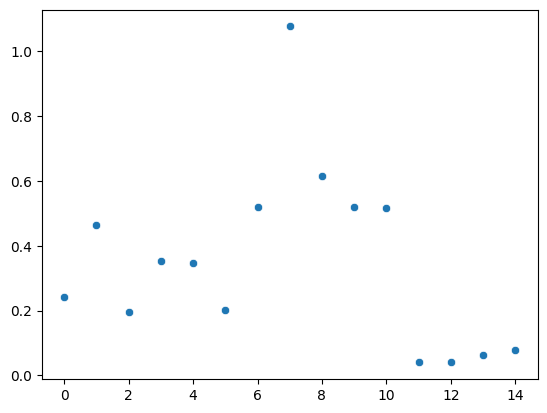

In [18]:
sb.scatterplot(maximum_differences_per_feature)
print(dev_set.columns.tolist())